In [ ]:
# !pip install xlrd==1.2.0
# !pip install openpyxl

In [1]:
import sys
sys.path.append("..")

import scripts.single_cell as single_cell
from sklearn import mixture

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.decomposition import PCA
import h5py

plt.ion()
plt.show()

def to_array(features):
    features = ' '.join(features.split()).replace(" ", ",")
    if features[1] == ',':
        features = f"[{features[2:]}"
    features = eval(features)
    return features

/usr/local/lib/python3.6/dist-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
r = pd.read_excel("../reports/scRNAseq_gmm.xlsx")

dataset_names = {
    'Quake_Smart-seq2_Trachea': "6. QS Trachea",
    'Quake_Smart-seq2_Diaphragm': "3. QS Diaphragm",
    'mouse_ES_cell': "8. Mouse ES",
    'Quake_Smart-seq2_Lung': "5. QS Lung",
    'Quake_10x_Limb_Muscle': "2. Q Limb Muscle",
    'mouse_bladder_cell': "9. Mouse Bladder",
    'Romanov': "7. Romanov",
    'Quake_Smart-seq2_Limb_Muscle': "4. QS Limb Muscle",
    'Muraro': "1. Muraro"
}

r['dataset_label'] = r['dataset_name'].apply(lambda x:dataset_names[x] )

In [3]:
best_ari = pd.DataFrame(columns=[
    "Ground truth subspaces", "Most compact subspaces"
])
best_sil = pd.DataFrame(columns=[
    "Ground truth subspaces", "Most compact subspaces"
])
rank = {}
for dataset, g in r.groupby('dataset_name'):
    g["rank_ari"] = g['ari'].rank(method='min', ascending=False)
    g["rank_silhouette"] = g['silhouette'].rank(method='min', ascending=False)
    rank[dataset] = g[g["rank_ari"] == 1]["rank_silhouette"].values[0]
    best_ari_s = g.sort_values(by="ari", ascending = False)[["ari", "silhouette"]].values[0]
    best_sil_s = g.sort_values(by="silhouette", ascending = False)[["ari", "silhouette"]].values[0]
    best_ari.loc[best_ari.shape[0]] = [best_ari_s[0], best_sil_s[0]]
    best_sil.loc[best_sil.shape[0]] = [best_ari_s[1], best_sil_s[1]]

In [4]:
def getHistBins(best):
    columns = best.columns
    d1 = best.values[:, 0]
    d2 = best.values[:, 1]

    x1, y1 = np.histogram(d1, bins = np.linspace(0,1, 10))
    x2, y2 = np.histogram(d2, bins = np.linspace(0,1, 10))

    m1 = pd.DataFrame()
    m1["values"] = np.append(x1,0)
    m1["bins"] = y1
    m1["Legend"] = columns[0]

    m2 = pd.DataFrame()
    m2["values"] = np.append(x2,0)
    m2["bins"] = y2
    m2["Legend"] = columns[1]

    m = pd.concat([m1, m2]).round(1)

    return m

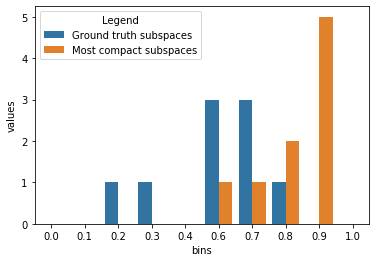

In [5]:
m = getHistBins(best_sil)
sns.barplot(data = m ,  x = "bins", y = "values", hue = "Legend", )

In [8]:
path = "../"

data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")

truth = np.array(data_mat['Y'])
data = np.array(data_mat['X'])
data = single_cell.preprocess_data(data, nb_genes = 3000, normalize_input=False)

(2881, 21143) (2881, 21143) keeping 3000 genes


Muraro
(2122, 19046) (2122, 19046) keeping 3000 genes
Quake_10x_Limb_Muscle
(3909, 23341) (3909, 23341) keeping 3000 genes
Quake_Smart-seq2_Diaphragm
(870, 23341) (870, 23341) keeping 3000 genes
Quake_Smart-seq2_Limb_Muscle
(1090, 23341) (1090, 23341) keeping 3000 genes
Quake_Smart-seq2_Lung
(1676, 23341) (1676, 23341) keeping 3000 genes
Quake_Smart-seq2_Trachea
(1350, 23341) (1350, 23341) keeping 3000 genes
Romanov
(2881, 21143) (2881, 21143) keeping 3000 genes
mouse_ES_cell
(2717, 24175) (2717, 24175) keeping 3000 genes
mouse_bladder_cell
(2746, 20670) (2746, 20670) keeping 3000 genes


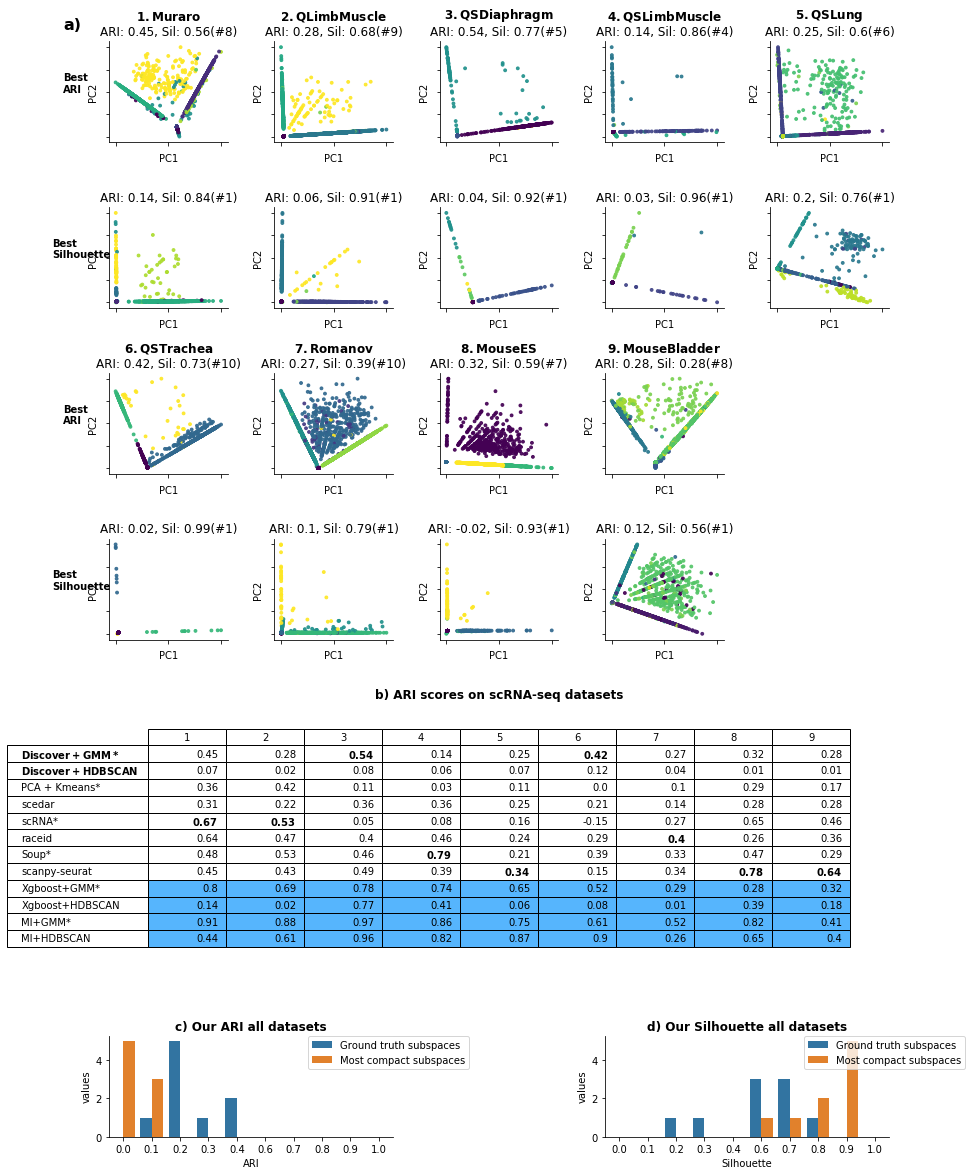

In [37]:
fig = plt.figure(figsize = (12,16))

ncol = 5
nrow = 7
gs = fig.add_gridspec(nrow, ncol)
for i, (dataset_label, g) in enumerate(r.groupby('dataset_label')):
    dataset = g["dataset_name"].unique()[0]
    print(dataset)
    row = (i) //ncol
    row *= 2
    col = i% ncol

    if i >9:
        break

    g["rank_ari"] = g['ari'].rank(method='min', ascending = False)
    g["rank_silhouette"] = g['silhouette'].rank(method='min', ascending = False)
    rank[dataset] = g[g["rank_ari"] ==1]["rank_silhouette"].values[0]
    
    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")

    truth = np.array(data_mat['Y'])
    data = np.array(data_mat['X'])
    data = single_cell.preprocess_data(data, nb_genes = 3000, normalize_input=False)
    n_clusters = np.unique(truth).shape[0]

    prop = "rank_ari"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])
        
#     partition = to_array(g[g[prop] ==1]['partition'].values[0])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=0).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)

    ax = fig.add_subplot(gs[row, col])

    plt.title(r'$\bf{}$'.format(dataset_names[dataset]) +
        f"\nARI: {ari}, Sil: {silhouette}(#{rank_silhouette})")

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    if i in [0, 5]:
        plt.text( -0.5, 0.5, "Best\nARI", fontweight = "bold")
    if i ==0:
        plt.text( -0.5, 1.2, "a)", fontweight = "bold", fontsize = 16)


    prop = "rank_silhouette"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])
#     partition = to_array(g[g[prop] ==1]['partition'].values[0])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=3).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)


    ax = fig.add_subplot(gs[row+1, col])

    plt.title(f"ARI: {ari}, Sil: {silhouette}(#{rank_silhouette})")

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    if i in [0, 5]:
        plt.text(-0.6, 0.5, "Best\nSilhouette", fontweight = "bold")
sns.despine()
plt.tight_layout()


df = pd.read_excel("../results.xlsx", sheet_name = 2)
df["Dataset Index"] = df["Dataset Index"].apply(lambda x: "$\\bf{" + x+  "}$" if x.startswith("Discover") else x)

df = df.set_index("Dataset Index", drop = True)

numeric_scores = df.values[:,: -1]

values = numeric_scores.copy().astype(str)

for i in range(numeric_scores.shape[1]):
    j = np.argmax(numeric_scores[:, i][:-4])
    values[ j, i]= "$\\bf{" + str(numeric_scores[ j, i]) +  "}$"


ax = fig.add_subplot(gs[-3:-1, :])
ax.axis("off")
plt.title("b) ARI scores on scRNA-seq datasets", fontweight = "bold")
table = ax.table(cellText=values,
          rowLabels=df.index,
          colLabels=np.arange(numeric_scores.shape[1]).astype(int) +1,
          loc='center'
        )
table.scale(0.9, 1.4)
for r in range(len(values)-3, len(values)+1):
    for c in range(values.shape[1]):
        table[(r, c)].set_facecolor("#56b5fd")

        
ax = fig.add_subplot(gs[-1, :2])
plt.title("c) Our ARI all datasets", fontweight = "bold")
# sns.histplot(data=best[["ARI ground truth", "ARI most compact subsapce",]])
m = getHistBins(best_ari)
sns.barplot(data = m ,  x = "bins", y = "values", hue = "Legend")
plt.legend(bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.)
plt.xlabel("ARI")
sns.despine()
ax = fig.add_subplot(gs[-1, 3:])
plt.title("d) Our Silhouette all datasets", fontweight = "bold")
m = getHistBins(best_sil)
sns.barplot(data = m ,  x = "bins", y = "values", hue = "Legend")
plt.legend(bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.)
plt.xlabel("Silhouette")
sns.despine()

plt.savefig(f"../images/scRNA-seq.pdf", bbox_inches='tight')

# Reduced version

In [9]:
r = pd.read_excel("../reports/scRNAseq_gmm.xlsx")

dataset_names = {
    'Quake_Smart-seq2_Trachea': "6. QS Trachea",
    'Quake_Smart-seq2_Diaphragm': "3. QS Diaphragm",
    'mouse_ES_cell': "Mouse ES",
    'Quake_Smart-seq2_Lung': "5. QS Lung",
    'Quake_10x_Limb_Muscle': "2. Q Limb Muscle",
    'mouse_bladder_cell': "9. Mouse Bladder",
    'Romanov': "Romanov",
    'Quake_Smart-seq2_Limb_Muscle': "4. QS Limb Muscle",
    'Muraro': "1. Muraro"
}

r['dataset_label'] = r['dataset_name'].apply(lambda x:dataset_names[x] )

(2881, 21143) (2881, 21143) keeping 3000 genes


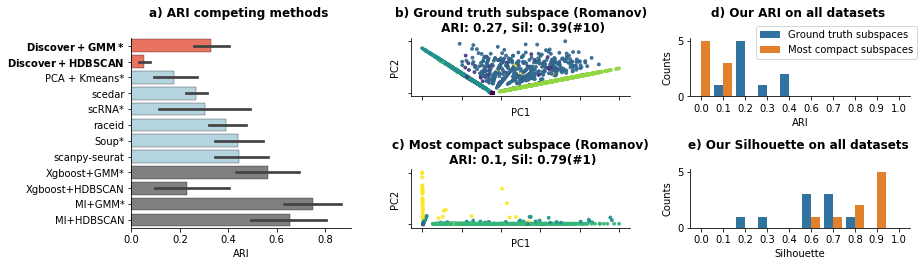

In [10]:
r = r[r["dataset_name"].isin(["Romanov", "mouse_ES_cell"])]
fig = plt.figure(figsize = (13,3.8))

ncol = 3
nrow = 2
gs = fig.add_gridspec(nrow, ncol)

ax = fig.add_subplot(gs[ :, 0])
df = pd.read_excel("../results.xlsx", sheet_name = 2)
df["Dataset Index"] = df["Dataset Index"].apply(lambda x: "$\\bf{" + x+  "}$" if x.startswith("Discover") else x)

df.drop("Avg", axis = 1, inplace = True)
df = pd.melt(df, id_vars = ["Dataset Index"] )
plt.title("a) ARI competing methods \n  ", fontweight = "bold")
g= sns.barplot(x = "value",y ="Dataset Index", data = df,
           palette=np.concatenate([['tomato']*2, ["lightblue"]* 6,  ["gray"]* 4]),
           edgecolor='black', #height=0.5,
    linewidth=0.3)
# plt.xticks(rotation = 90)
plt.xlabel("ARI")
plt.ylabel("")
sns.despine()

for i, (dataset, g) in enumerate(r.groupby('dataset_name')):
    col = 0

    if i >=1: # show only 10 datasets
        break

    g["rank_ari"] = g['ari'].rank(method='min', ascending = False)
    g["rank_silhouette"] = g['silhouette'].rank(method='min', ascending = False)
    rank[dataset] = g[g["rank_ari"] ==1]["rank_silhouette"].values[0]
    
    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")

    truth = np.array(data_mat['Y'])
    data = np.array(data_mat['X'])
    data = single_cell.preprocess_data(data, nb_genes = 3000, normalize_input=False)
    n_clusters = np.unique(truth).shape[0]

    prop = "rank_ari"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=0).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)

    ax = fig.add_subplot(gs[0, 1])

    
    plt.title("b) Ground truth subspace (Romanov)" +
        f"\n ARI: {ari}, Sil: {silhouette}(#{rank_silhouette})",
              fontweight = "bold")


    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel("PC1")
    plt.ylabel("PC2")



    prop = "rank_silhouette"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=3).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)


    ax = fig.add_subplot(gs[1, 1])

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("c) Most compact subspace (Romanov)" +
        f"\n ARI: {ari}, Sil: {silhouette}(#{rank_silhouette})",
              fontweight = "bold")


sns.despine()

ax = fig.add_subplot(gs[ 0, 2])
plt.title("d) Our ARI on all datasets \n  ", fontweight = "bold")
m = getHistBins(best_ari)
sns.barplot(data = m ,  x = "bins", y = "values", hue = "Legend")
plt.legend(bbox_to_anchor=(0.3, 1.2), loc=2, borderaxespad=0., title = "")
plt.xlabel("ARI")
plt.ylabel("Counts")

sns.despine()
ax = fig.add_subplot(gs[ 1, 2])
plt.title("e) Our Silhouette on all datasets \n ", fontweight = "bold")
m = getHistBins(best_sil)
sns.barplot(data = m ,  x = "bins", y = "values", hue = "Legend", )
ax.get_legend().remove()
plt.xlabel("Silhouette")
plt.ylabel("Counts")
sns.despine()
plt.tight_layout()
plt.savefig(f"../images/scRNAseq_small.pdf", bbox_inches='tight')

In [ ]:
r = r[r["dataset_name"].isin(["Romanov", "mouse_ES_cell"])]
fig = plt.figure(figsize = (14,3.8))

ncol = 9
nrow = 2
gs = fig.add_gridspec(nrow, ncol)

for i, (dataset, g) in enumerate(r.groupby('dataset_name')):
#     col = (i) //ncol
#     col *= 2
    col = 0
    row = i

    if i >=1: # show only 10 datasets
        break

    g["rank_ari"] = g['ari'].rank(method='min', ascending = False)
    g["rank_silhouette"] = g['silhouette'].rank(method='min', ascending = False)
    rank[dataset] = g[g["rank_ari"] ==1]["rank_silhouette"].values[0]
    
    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")

    truth = np.array(data_mat['Y'])
    data = np.array(data_mat['X'])
    data = single_cell.preprocess_data(data, nb_genes = 3000, normalize_input=False)
    n_clusters = np.unique(truth).shape[0]

    prop = "rank_ari"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=0).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)

    ax = fig.add_subplot(gs[row, :2])

    
    if i == 0:
        lab = r'$\bf{}$'.format("a) Best ARI")
    else:
        lab = ""
    plt.title(lab +
        f"\nARI: {ari}, Sil: {silhouette}(#{rank_silhouette})")
    plt.text( -0.45, 0.45, f"{dataset_names[dataset]}\nDataset", fontweight = "bold")

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel("PC1")
    plt.ylabel("PC2")



    prop = "rank_silhouette"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=3).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)


    ax = fig.add_subplot(gs[row, 2:4])

    if i == 0:
        lab = r'$\bf{}$'.format("b) Best Silhouette") + "\n"
    else:
        lab = ""
    plt.title(lab + f"ARI: {ari}, Sil: {silhouette}(#{rank_silhouette})")

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
#     if i in [0, 5]:
#         plt.text(-0.6, 0.5, "Best\nSilhouette", fontweight = "bold")
sns.despine()
plt.tight_layout()


ax = fig.add_subplot(gs[ :, 5:-2])
df = pd.read_excel("../results.xlsx", sheet_name = 2)
df["Dataset Index"] = df["Dataset Index"].apply(lambda x: "$\\bf{" + x+  "}$" if x.startswith("Discover") else x)

df.drop("Avg", axis = 1, inplace = True)
df = pd.melt(df, id_vars = ["Dataset Index"] )
plt.title("c) ARI competing methods", fontweight = "bold")
g= sns.barplot(x = "value",y ="Dataset Index", data = df,
           palette=np.concatenate([['tomato']*2, ["lightblue"]* 8,  ["gray"]* 4]),
           edgecolor='black',
    linewidth=1.5)
# plt.xticks(rotation = 90)
plt.xlabel("ARI")
plt.ylabel("")
sns.despine()
        

ax = fig.add_subplot(gs[ 0, -2:])
plt.title("d) ARI scores", fontweight = "bold")
b = best[["ARI ground truth", "ARI most compact subsapce",]]
b.columns = ["ground truth", "max Silhoutte"]
sns.histplot(data=b)
plt.xlabel("ARI")

sns.despine()
ax = fig.add_subplot(gs[ 1, -2:])
plt.title("e) Silhouette scores", fontweight = "bold")
b = best[["Silhouette ground truth","Silhouette most compact subsapce",]]
b.columns = ["ground truth", "max Silhoutte"]
sns.histplot(data=b)
plt.xlabel("Silhouette")
sns.despine()
# plt.tight_layout()
plt.savefig(f"../images/scRNAseq_small.pdf", bbox_inches='tight')

In [ ]:
r = r[r["dataset_name"].isin(["Romanov", "mouse_ES_cell"])]
fig = plt.figure(figsize = (16,3.8))

ncol = 5
nrow = 2
gs = fig.add_gridspec(nrow, ncol)

for i, (dataset, g) in enumerate(r.groupby('dataset_name')):
#     col = (i) //ncol
#     col *= 2
    col = i
    row = 0

    if i >1: # show only 10 datasets
        break

    g["rank_ari"] = g['ari'].rank(method='min', ascending = False)
    g["rank_silhouette"] = g['silhouette'].rank(method='min', ascending = False)
    rank[dataset] = g[g["rank_ari"] ==1]["rank_silhouette"].values[0]
    
    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")

    truth = np.array(data_mat['Y'])
    data = np.array(data_mat['X'])
    data = single_cell.preprocess_data(data, nb_genes = 3000, normalize_input=False)
    n_clusters = np.unique(truth).shape[0]

    prop = "rank_ari"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=0).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)

    if i == 0:
        lab = r'$\bf{}$'.format(f"a) {dataset_names[dataset]}")
        ax = fig.add_subplot(gs[row, 0])
    else:
        ax = fig.add_subplot(gs[row, 1])
        lab = r'$\bf{}$'.format(f"b) {dataset_names[dataset]}")


    plt.title(lab +
        f"\nARI: {ari}, Sil: {silhouette}(#{rank_silhouette})")
    if i ==0:
        plt.text( -0.7, 0.45, f"Subspaces\nbest\nARI", fontweight = "bold")

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])



    prop = "rank_silhouette"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=3).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)



    if i == 0:
        ax = fig.add_subplot(gs[1, 0])
    else:
        ax = fig.add_subplot(gs[1, 1])

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.title(f"\nARI: {ari}, Sil: {silhouette}(#{rank_silhouette})")
    if i ==0:
        plt.text( -0.7, 0.45, f"Subspaces\nbest\nSilhouette", fontweight = "bold")

sns.despine()
plt.tight_layout()


ax = fig.add_subplot(gs[ :, 2])
df = pd.read_excel("../results.xlsx", sheet_name = 0)
df["Dataset Index"] = df["Dataset Index"].apply(lambda x: "$\\bf{" + x+  "}$" if x.startswith("Discover") else x)

df.drop("Avg", axis = 1, inplace = True)
df = pd.melt(df, id_vars = ["Dataset Index"] )
plt.title("c) ARI competing methods", fontweight = "bold")
g= sns.barplot(x = "value",y ="Dataset Index", data = df,
           palette=np.concatenate([['tomato']*2, ["lightblue"]* 8,  ["gray"]* 4]),
           edgecolor='black',
    linewidth=1.5)
# plt.xticks(rotation = 90)
plt.xlabel("ARI")
plt.ylabel("")
sns.despine()
        

ax = fig.add_subplot(gs[ 0, -2])
plt.grid()
plt.title("d) ARI ground \ntruth subspaces", fontweight = "bold")
# b = best[["ARI ground truth", "ARI most compact subsapce",]]
# b.columns = ["ground truth", "max Silhoutte"]
sns.histplot(data=best["ARI ground truth"])
plt.xlim((0,1))
plt.ylim((0,10))
plt.xlabel("ARI")
sns.despine()

ax = fig.add_subplot(gs[ 1, -2])
plt.grid()
plt.title("e) ARI most \ncompact subspaces", fontweight = "bold")
# b = best[["ARI ground truth", "ARI most compact subsapce",]]
# b.columns = ["ground truth", "max Silhoutte"]
sns.histplot(data=best["ARI most compact subsapce"])
plt.xlim((0,1))
plt.ylim((0,10))
plt.xlabel("ARI")
sns.despine()


ax = fig.add_subplot(gs[ 0, -1])
plt.grid()
plt.title("f) Silhouette ground \ntruth subspaces", fontweight = "bold")
# b = best[["ARI ground truth", "ARI most compact subsapce",]]
# b.columns = ["ground truth", "max Silhoutte"]
sns.histplot(data=best["Silhouette ground truth"])
plt.xlim((0,1))
plt.ylim((0,10))
plt.xlabel("ARI")
sns.despine()

ax = fig.add_subplot(gs[ 1, -1])
plt.grid()
plt.title("g) Silhouette most \ncompact subspaces", fontweight = "bold")
sns.histplot(data=best["Silhouette most compact subsapce"])

plt.xlim((0,1))
plt.ylim((0,10))
plt.xlabel("ARI")
sns.despine()

plt.tight_layout()
plt.savefig(f"../images/scRNAseq_small.pdf", bbox_inches='tight')

In [ ]:
df = pd.read_excel("../results.xlsx", sheet_name = 2)

In [ ]:

r = r[r["dataset_name"].isin(["Romanov", "mouse_ES_cell"])]
fig = plt.figure(figsize = (5,9))

ncol = 2
nrow = 5
gs = fig.add_gridspec(nrow, ncol)
# plt.suptitle("a) Best subpsaces by ARI and Silhouette scores")
for i, (dataset, g) in enumerate(r.groupby('dataset_name')):
    row = (i) //ncol
    row *= 2
    col = i% ncol

    if i >1: # show only 10 datasets
        break

    g["rank_ari"] = g['ari'].rank(method='min', ascending = False)
    g["rank_silhouette"] = g['silhouette'].rank(method='min', ascending = False)
    rank[dataset] = g[g["rank_ari"] ==1]["rank_silhouette"].values[0]
    
    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")

    truth = np.array(data_mat['Y'])
    data = np.array(data_mat['X'])
    data = single_cell.preprocess_data(data, nb_genes = 3000, normalize_input=False)
    n_clusters = np.unique(truth).shape[0]

    prop = "rank_ari"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=0).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)

    ax = fig.add_subplot(gs[row, col])
    title = f"{i+1}. {dataset}"
    plt.title(r'$\bf{}$'.format(dataset_names[dataset]) +
        f"\nARI: {ari}, Sil: {silhouette}(#{rank_silhouette})")

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    if i in [0, 5]:
        plt.text( -0.5, 0.5, "Best\nARI", fontweight = "bold")
    if i ==0:
        plt.text( -0.5, 1.2, "a)", fontweight = "bold", fontsize = 16)


    prop = "rank_silhouette"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=3).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)


    ax = fig.add_subplot(gs[row+1, col])

    plt.title(f"ARI: {ari}, Sil: {silhouette}(#{rank_silhouette})")

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    if i in [0, 5]:
        plt.text(-0.6, 0.5, "Best\nSilhouette", fontweight = "bold")
sns.despine()
plt.tight_layout()


ax = fig.add_subplot(gs[-3, :])
df = pd.read_excel("../results.xlsx", sheet_name = 2)
df["Dataset Index"] = df["Dataset Index"].apply(lambda x: "$\\bf{" + x+  "}$" if x.startswith("Discover") else x)

df.drop("Avg", axis = 1, inplace = True)
df = pd.melt(df, id_vars = ["Dataset Index"] )
plt.title("b) ARI scores by method", fontweight = "bold")
g= sns.barplot(y = "value",x ="Dataset Index", data = df,
           palette=np.concatenate([['tomato']*2, ["lightblue"]* 8,  ["gray"]* 4]),
           edgecolor='black',
    linewidth=1.5)
plt.xticks(rotation = 90)
plt.ylabel("ARI")
plt.xlabel("")
sns.despine()
        
        
ax = fig.add_subplot(gs[-1, 0])
plt.title("c) ARI scores", fontweight = "bold")
b = best[["ARI ground truth", "ARI most compact subsapce",]]
b.columns = ["ground truth", "max Silhoutte"]
sns.histplot(data=b)
plt.xlabel("ARI")

sns.despine()
ax = fig.add_subplot(gs[-1, 1])
plt.title("d) Silhouette scores", fontweight = "bold")
b = best[["Silhouette ground truth","Silhouette most compact subsapce",]]
b.columns = ["ground truth", "max Silhoutte"]
sns.histplot(data=b)
plt.xlabel("Silhouette")
sns.despine()
# plt.tight_layout()
plt.savefig(f"../images/scRNA-seq_small.pdf", bbox_inches='tight')

In [ ]:
df = df.set_index("Dataset Index", drop = True)

In [ ]:
numeric_scores = df.values[:,: -1]

In [ ]:
values = numeric_scores.copy().astype(str)

In [ ]:
for i in range(numeric_scores.shape[1]):
    j = np.argmax(numeric_scores[:, i][:-4])
    values[ j, i]= "$\\bf{" + str(numeric_scores[ j, i]) +  "}$"

In [ ]:
plt.figure(figsize = (12,8))
ax = plt.subplot(1, 1, 1)
ax.axis("off")
table = ax.table(cellText=values,
          rowLabels=df.index,
          colLabels=df.columns,
          loc='center left'
        )

for r in range(len(values)-3, len(values)+1):
    for c in range(values.shape[1]):
        table[(r, c)].set_facecolor("#56b5fd")
# plt.title("(a)", fontweight = "bold")
# table.scale(0.9, 1.5)
# table.set_fontsize(12)

In [ ]:
["alon", "borovecki", "chiaretti", "christensen", "golub", "gordon", "khan", "sorlie", "su", "yeoh", "west"]


In [ ]:
sns.barplot(y = "Dataset Index", x = 1, data = df)
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[1].set_fontweight('bold') 
plt.gca().get_yticklabels()[-4].set_color('red') 
plt.gca().get_yticklabels()[-3].set_color('red') 
plt.gca().get_yticklabels()[-2].set_color('red') 
plt.gca().get_yticklabels()[-1].set_color('red') 
plt.ylabel("")
plt.xlabel("ARI")
plt.grid()
sns.despine()